**Sentiment Analysis**

Data for the project comes from the Kaggle website: https://www.kaggle.com/datasets/joebeachcapital/restaurant-reviews/

Build a sentiment analysis model:

* using a recurrent network (LSTM/GRU/two-way network) other than a basic RNN
* using a CNN network
* with a base of pre-trained word embeddings
* with fine-tuning of the language model (other than basic BERT)

##**#1 - Oczyszczenie i analiza danych**

Import biblotek

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install -U datasets

!pip install -U spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency res

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch
import torch.nn as nn
import torch.optim as optim
from wordcloud import WordCloud
import spacy
import string
import time
import random

Oczyszczanie danych i prezentacja rozkładu klas

In [ ]:
file_path = "/content/drive/MyDrive/SEM3/ZUM/ZUM_Zadanie_praca_domowa/Restaurant reviews.csv" # Ścieżka do pliku

restaurant_data = pd.read_csv(file_path)
restaurant_data = restaurant_data.sample(frac=True)
restaurant_data.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
3955,Deli 9 Bistro,Dattaraj Naik,Tried the chicken stuffed steak and the fish s...,5,"12 Reviews , 11 Followers",12/22/2018 18:56,2,NaN
2586,Tiki Shack,Aishwarya Gupta,Tiki shack is a cool place to hang out with fr...,5,"27 Reviews , 81 Followers",2/24/2019 2:41,2,NaN
2388,Amul,Sai Anish,Names of the items on the top of boxes must be...,4,1 Review,7/22/2018 22:51,0,NaN
8740,American Wild Wings,Shantam Sinha,Terrible wings. Not sure if this was just a on...,1,"3 Reviews , 1 Follower",2/24/2019 20:31,0,NaN
3005,Pot Pourri,Saikrishna Javvaji,went for A-LA-Carte here.. Heard a lot about t...,4,"1 Review , 75 Followers",5/11/2019 16:00,0,NaN


In [ ]:
# Usunięcie zbędnych informacji (kolumn)

restaurant_data = restaurant_data.drop(['7514', 'Pictures', 'Time', 'Metadata', 'Restaurant', 'Reviewer'],axis=1)
restaurant_data.head(5)

,Review,Rating
3955,Tried the chicken stuffed steak and the fish s...,5
2586,Tiki shack is a cool place to hang out with fr...,5
2388,Names of the items on the top of boxes must be...,4
8740,Terrible wings. Not sure if this was just a on...,1
3005,went for A-LA-Carte here.. Heard a lot about t...,4


In [ ]:
# Sprawdzenie czy występują NULLe

print(restaurant_data.isnull().any())
print(restaurant_data.isnull().sum())
print(f"Początkowa ilość wierszy w datasecie: {len(restaurant_data)}")

Review    True
Rating    True
dtype: bool
Review    45
Rating    38
dtype: int64
Początkowa ilość wierszy w datasecie: 10000


In [ ]:
# Usunięcie wartości NULL

restaurant_data.dropna(subset=['Review', 'Rating'], inplace=True)
print(f"Ilość wierszy w datasecie po usunięciu NULLi: {len(restaurant_data)}")

Ilość wierszy w datasecie po usunięciu NULLi: 9955


In [ ]:
# Usunięcie duplikatów

restaurant_data.drop_duplicates(subset=['Review'], keep='first', inplace=True)

In [ ]:
# Usunięcie wartości pustych (krótsze niż 1 znak)

restaurant_data['len'] = len(restaurant_data['Review'])
restaurant_data = restaurant_data[restaurant_data['len'] > 1]
restaurant_data = restaurant_data.drop(['len'],axis=1)
restaurant_data.head(5)

,Review,Rating
3955,Tried the chicken stuffed steak and the fish s...,5
2586,Tiki shack is a cool place to hang out with fr...,5
2388,Names of the items on the top of boxes must be...,4
8740,Terrible wings. Not sure if this was just a on...,1
3005,went for A-LA-Carte here.. Heard a lot about t...,4


In [ ]:
# Usunięcie znaków interpunkcyjnych

# Wykorzystanie funkcji RegEx
restaurant_data['Review']  = restaurant_data['Review'].str.replace(r'[^\w\s]+', '')
restaurant_data.head()

<ipython-input-10-a4989bbc7e0d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurant_data['Review']  = restaurant_data['Review'].str.replace(r'[^\w\s]+', '')


,Review,Rating
3955,Tried the chicken stuffed steak and the fish s...,5
2586,Tiki shack is a cool place to hang out with fr...,5
2388,Names of the items on the top of boxes must be...,4
8740,Terrible wings Not sure if this was just a one...,1
3005,went for ALACarte here Heard a lot about this ...,4


In [ ]:
# Usunięcie stop words

nlp = spacy.load('en_core_web_md', disable = ['ner', 'parser'])
nlp.add_pipe('sentencizer')


def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

restaurant_data['Review'] = restaurant_data['Review'].apply(remove_stopwords)
restaurant_data.head(5)

,Review,Rating
3955,Tried chicken stuffed steak fish steak genuine...,5
2586,Tiki shack cool place hang friends It open roo...,5
2388,Names items boxes present distinguish,4
8740,Terrible wings Not sure inedibly spicy Good fr...,1
3005,went ALACarte Heard lot previously went excite...,4


In [ ]:
# Lematyzacja

def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

restaurant_data['Review'] =  restaurant_data['Review'].apply(lemmatize)
restaurant_data.sample(5)

,Review,Rating
7437,expectedover price quantity givingnot worthy o...,2
9917,I Chinese Pavilion time good experience the am...,5
2803,the Behrouz Biryani Royal Biryani the flavour ...,5
9898,deliver time,5
9201,we celebrate anniversary there set menu welcom...,3


In [ ]:
# Eliminacja rozróżnienia na małe i duże litery

restaurant_data['Review']  = restaurant_data['Review'].apply(lambda x: " ".join(x.upper() for x in x.split()))
restaurant_data.head()

,Review,Rating
3955,TRY CHICKEN STUFF STEAK FISH STEAK GENUINELY I...,5
2586,TIKI SHACK COOL PLACE HANG FRIEND IT OPEN ROOF...,5
2388,NAME ITEM BOX PRESENT DISTINGUISH,4
8740,TERRIBLE WING NOT SURE INEDIBLY SPICY GOOD FRY...,1
3005,GO ALACARTE HEARD LOT PREVIOUSLY GO EXCITEMENT...,4


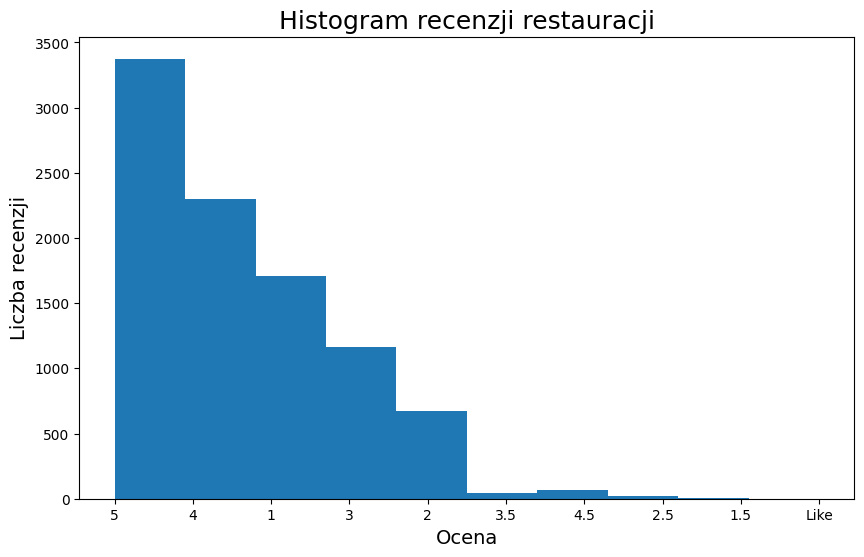

In [ ]:
# Histogram recenzji

plt.figure(figsize=(10,6))
plt.title('Histogram recenzji restauracji', fontsize=18)
plt.hist(restaurant_data['Rating'])
plt.xlabel('Ocena', fontsize=14)
plt.ylabel('Liczba recenzji', fontsize=14)
plt.show()

In [ ]:
# Oczyszczenie kolumny decyzjnej Rating
# Sentyment dzieli się tylko na 2 klasy - pozytywny i negatywny

restaurant_data = restaurant_data[restaurant_data['Rating'] != 'Like']
restaurant_data['Rating'] = restaurant_data['Rating'].astype('float').round(2)
restaurant_data = restaurant_data[restaurant_data['Rating'] != 3]

<ipython-input-15-20098f9dcf2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_data['Rating'] = restaurant_data['Rating'].astype('float').round(2)


In [ ]:
# Dane zamieniamy z ocen w skali 1-5 na "sentyment" recenzji

def transform(rating):
    if rating > 3:
        return 1 # "POSITIVE"
    if rating < 3:
        return 0 # "NEGATIVE"

restaurant_data['Rating'] = restaurant_data['Rating'].apply(transform)
restaurant_data.head()

,Review,Rating
3955,TRY CHICKEN STUFF STEAK FISH STEAK GENUINELY I...,1
2586,TIKI SHACK COOL PLACE HANG FRIEND IT OPEN ROOF...,1
2388,NAME ITEM BOX PRESENT DISTINGUISH,1
8740,TERRIBLE WING NOT SURE INEDIBLY SPICY GOOD FRY...,0
3005,GO ALACARTE HEARD LOT PREVIOUSLY GO EXCITEMENT...,1


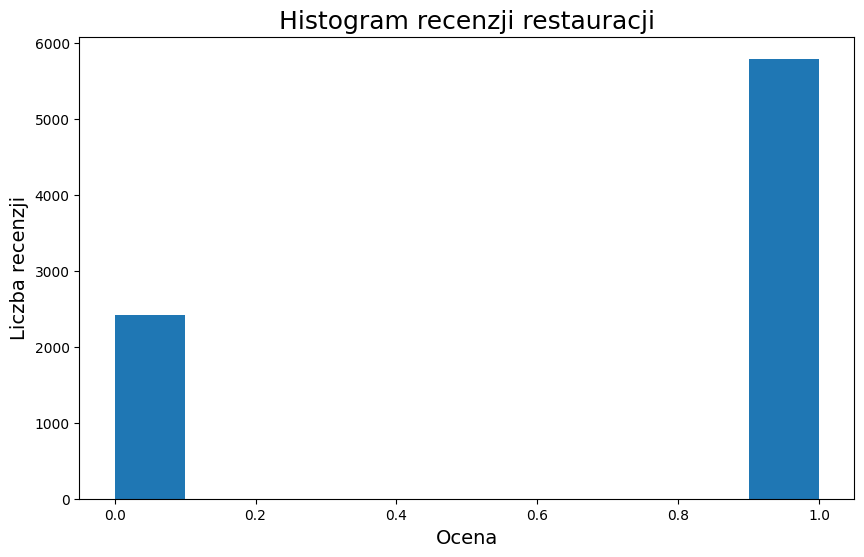

In [ ]:
# Histogram recenzji po transformacji

plt.figure(figsize=(10,6))
plt.title('Histogram recenzji restauracji', fontsize=18)
plt.hist(restaurant_data['Rating'])
plt.xlabel('Ocena', fontsize=14)
plt.ylabel('Liczba recenzji', fontsize=14)
plt.show()

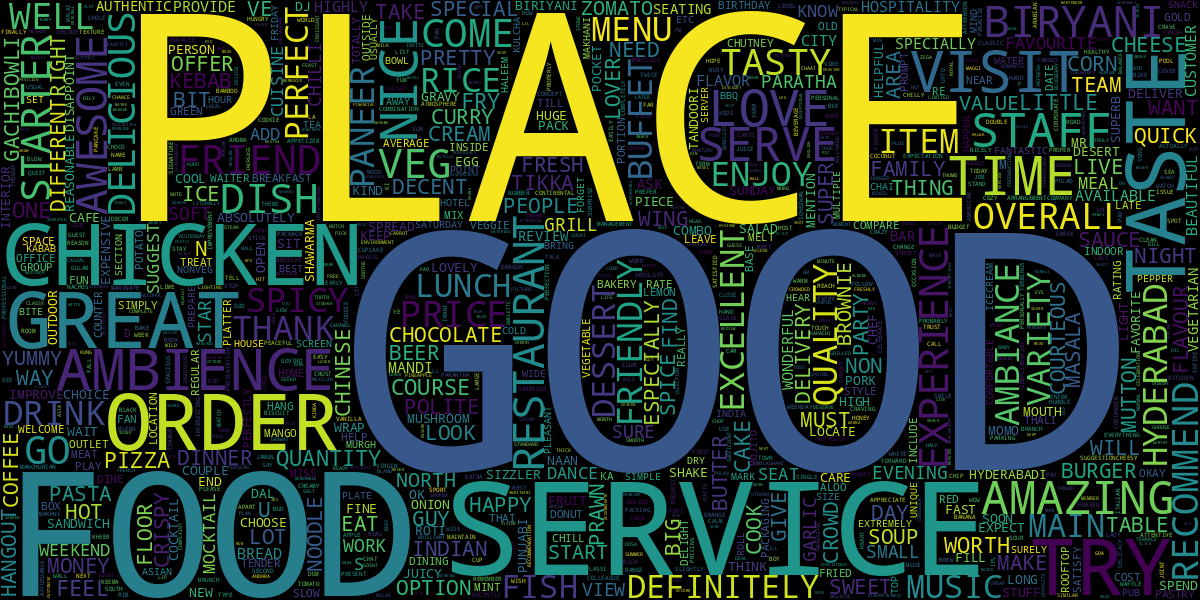

In [ ]:
# Chmura słów

text = ' '.join(restaurant_data[restaurant_data['Rating']==1]['Review'])
wc_neg = WordCloud(max_words=1000, width = 1200, height = 600, collocations=False).generate(text)
wc_neg.to_image()

##**#2.1 - Budowa modelu analizy sentymentu [LSTM]**

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from datasets import Dataset
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

In [ ]:
data_lstm = restaurant_data

data_lstm.rename(columns={'Rating':'label', 'Review':'text'}, inplace=True)
data_lstm.sample(5)

,text,label
8011,HI TEAMI BIG FAN RESTAURANT I VISIT FREQUENTLY...,0
8406,SINCE PLACE CLOSE OFFICE SERVE SOUTH INDIAN DE...,1
5378,I RATE PLACE 4 5 FOOD STARTER TASTY DO NOT VAR...,1
5943,I ORDER CAKE SUGGEST MRRAJESH FLAVOUR MANGO PA...,1
5176,AWESOMEGOOD,1


In [ ]:
import torchdata.datapipes as dp

data_lstm.to_csv('data_lstm_csv.csv', sep='\t', encoding='utf-8', index=False, header=False)
f = 'data_lstm_csv.csv'
data_pipe = dp.iter.IterableWrapper([f])
data_pipe = dp.iter.FileOpener(data_pipe, mode='rb')
data_pipe = data_pipe.parse_csv(skip_lines = 0, delimiter = '\t', as_tuple = True)

In [ ]:
for sample in data_pipe:
  print(sample)
  break

('TRY CHICKEN STUFF STEAK FISH STEAK GENUINELY IMPRESSIVE NOT WAITER FRIENDLY FAST SERVICE WITH ZOMATO GOLD MEMBERSHIP I AVAIL 1 1 OFFER DESTROY HUNGER PANG', '1')


In [ ]:
# Podział zbioru na testowy i treningowy 10/90

data_list = list(data_pipe)
random.shuffle(data_list)

split_ratio = 0.9
train_size = int(split_ratio * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

train_iter = iter(train_data)
test_iter = iter(test_data)

In [ ]:
# Tokenizacja

tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for text, _ in data_iter:
      yield tokenizer(text)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
# Budowa słownika

MAX_TOKENS = 25000

vocab = build_vocab_from_iterator(
    yield_tokens(train_iter),
    specials=['<unk>'],
    max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

len(vocab)

14791

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else 0

def collate_batch(batch):
    text_list, label_list, lengths = [], [], []
    for ( _text, _label) in batch:
        processed_text = torch.tensor(text_pipeline(_text))
        if processed_text.size(0) > 0:
          label_list.append(label_pipeline(_label))
          text_list.append(processed_text)
          lengths.append(processed_text.size(0))
    if len(lengths) == 0:
        return None, None, None

    label_list = torch.tensor(label_list, dtype=torch.float32).to(torch.int64)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)
    return text_list.long(), label_list, lengths

In [ ]:
batch_size = 64
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
      super().__init__()
      self.embedding = nn.Embedding(input_dim, embedding_dim)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim)
      self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
      embedded = self.embedding(text)
      packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
      packed_output, (hidden, cell) = self.lstm(packed_embedded)
      output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
      return self.fc(hidden.squeeze(0))

In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3

model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model ma {count_parameters(model):,} parametrów')

Model ma 1,846,463 parametrów


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in dataloader:
      #label_list, text_list, lenghts
      texts, labels, lengths = batch
      texts, labels = texts.to(device), labels.to(device, dtype=torch.long)
      optimizer.zero_grad()

      predictions = model(texts, lengths).squeeze(1)
      loss = criterion(predictions, labels)
      acc = categorical_accuracy(predictions, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
        texts, labels, lengths = batch
        texts, labels = texts.to(device), labels.to(device, dtype=torch.long)

        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_dataloader, criterion)

    end_time = time.time()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.073 | Train Acc: 52.91%
	 Val. Loss: 1.053 |  Val. Acc: 62.22%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.038 | Train Acc: 65.32%
	 Val. Loss: 1.019 |  Val. Acc: 68.56%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.006 | Train Acc: 69.45%
	 Val. Loss: 0.989 |  Val. Acc: 70.39%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.977 | Train Acc: 70.17%
	 Val. Loss: 0.961 |  Val. Acc: 70.39%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.951 | Train Acc: 70.65%
	 Val. Loss: 0.936 |  Val. Acc: 70.63%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.928 | Train Acc: 70.52%
	 Val. Loss: 0.914 |  Val. Acc: 70.63%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.906 | Train Acc: 70.55%
	 Val. Loss: 0.893 |  Val. Acc: 70.63%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.886 | Train Acc: 70.55%
	 Val. Loss: 0.874 |  Val. Acc: 70.63%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.868 | Train Acc: 70.61%
	 Val. Loss: 0.857 |  Val. Acc: 70.63%
Epoch: 10 | Epoch Time: 0m 2

##**#2.2 - Budowa modelu analizy sentymentu [CNN]**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [ ]:
data_cnn = restaurant_data

data_cnn.rename(columns={'Rating':'label', 'Review':'text'}, inplace=True)
data_cnn.sample(5)

,text,label
9060,HAVE GO BIRTHDAY FRIEND THE AMBIENCE GOOD THE ...,1
490,IF FAN BREWERY U VISIT PLACE I TASTE BEER TAST...,1
2081,OKAY I VEG PERSON USUALLY RAKSHA BANDHAN YESTE...,1
6596,FRIENDLY STAFF GOOD LIVE MUSIC DECENT FOOD YOU...,0
675,OVERPRICE CRAP HEALTHY FOOD THE FOOD INDUSTRY ...,0


In [ ]:
import torchdata.datapipes as dp

data_cnn.to_csv('data_cnn_csv.csv', sep='\t', encoding='utf-8', index=False, header=False)
f = 'data_cnn_csv.csv'
data_pipe = dp.iter.IterableWrapper([f])
data_pipe = dp.iter.FileOpener(data_pipe, mode='rb')
data_pipe = data_pipe.parse_csv(skip_lines = 0, delimiter = '\t', as_tuple = True)

In [ ]:
for sample in data_pipe:
  print(sample)
  break

('TRY CHICKEN STUFF STEAK FISH STEAK GENUINELY IMPRESSIVE NOT WAITER FRIENDLY FAST SERVICE WITH ZOMATO GOLD MEMBERSHIP I AVAIL 1 1 OFFER DESTROY HUNGER PANG', '1')


In [ ]:
# Podział zbioru na testowy i treningowy 10/90

data_list = list(data_pipe)
random.shuffle(data_list)

split_ratio = 0.9
train_size = int(split_ratio * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

train_iter = iter(train_data)
test_iter = iter(test_data)

In [ ]:
# Tokenizacja

tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for text, _ in data_iter:
      yield tokenizer(text)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
# Budowa słownika

MAX_TOKENS = 25000

vocab = build_vocab_from_iterator(
    yield_tokens(train_iter),
    specials=['<unk>'],
    max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

len(vocab)

14701

In [ ]:
vocab_size = len(vocab)
embedding_dim = 100
max_len = 512

In [ ]:
# Podział na dane testowe i treningowe
x_train, x_test, y_train, y_test = train_test_split(data_cnn['text'], data_cnn['label'], test_size=0.1, random_state=42)

# Tokenizacja
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)

seq_train = tokenizer.texts_to_sequences(x_train)
x_train_padded = pad_sequences(seq_train, maxlen=max_len)
seq_test = tokenizer.texts_to_sequences(x_test)
x_test_padded = pad_sequences(seq_test, maxlen=max_len)

In [ ]:
filtered_sequences_train = [seq for seq in seq_train if seq]

if filtered_sequences_train:
    vocab_size = max([max(seq) for seq in filtered_sequences_train]) + 1
else:
    raise ValueError("Brak sekwencji treningowych")

# Budowa modelu
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_test_padded, y_test))

Epoch 1/10
231/231 [==============================] - 37s 143ms/step - loss: 0.3406 - accuracy: 0.8458 - val_loss: 0.1874 - val_accuracy: 0.9329
Epoch 2/10
231/231 [==============================] - 15s 67ms/step - loss: 0.1201 - accuracy: 0.9528 - val_loss: 0.1853 - val_accuracy: 0.9317
Epoch 3/10
231/231 [==============================] - 10s 44ms/step - loss: 0.0442 - accuracy: 0.9859 - val_loss: 0.2287 - val_accuracy: 0.9159
Epoch 4/10
231/231 [==============================] - 9s 39ms/step - loss: 0.0237 - accuracy: 0.9907 - val_loss: 0.2493 - val_accuracy: 0.9183
Epoch 5/10
231/231 [==============================] - 4s 19ms/step - loss: 0.0157 - accuracy: 0.9949 - val_loss: 0.2623 - val_accuracy: 0.9159
Epoch 6/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0122 - accuracy: 0.9953 - val_loss: 0.2900 - val_accuracy: 0.9159
Epoch 7/10
231/231 [==============================] - 5s 24ms/step - loss: 0.0109 - accuracy: 0.9961 - val_loss: 0.2977 - val_accuracy: 0.

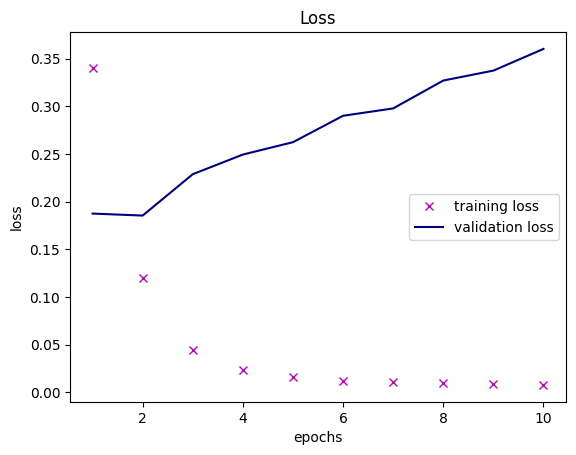

In [ ]:
# Wykres zmian straty w czasie uczenia modelu

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1,len(loss_values)+1)
plt.plot(epochs, loss_values, "mx", label='training loss')
plt.plot(epochs, val_loss_values, "navy", label = 'validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Loss')
plt.legend()

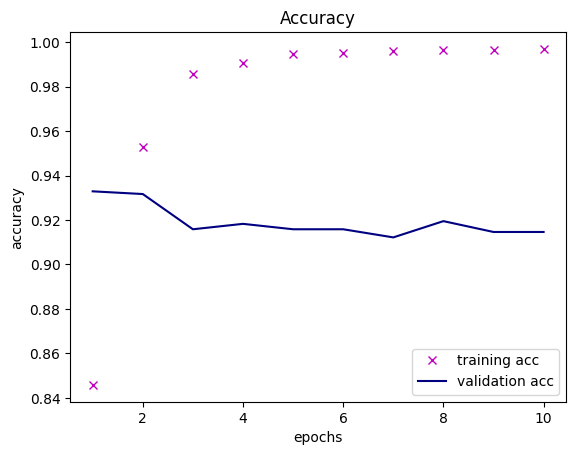

In [ ]:
# Wykres zmian dokładności w czasie uczenia modelu

history_dict = history.history
acc = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1,len(loss_values)+1)
plt.plot(epochs, acc, "mx", label='training acc')
plt.plot(epochs, val_acc_values, "navy", label = 'validation acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Accuracy')
plt.legend()

##**#2.3 - Budowa modelu analizy sentymentu [Pre-trained Word Embedding]**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

In [ ]:
data_embedding = restaurant_data

data_embedding.rename(columns={'Rating':'label', 'Review':'text'}, inplace=True)
data_embedding.sample(5)

,text,label
2983,FOOD HOT,0
2450,COME TAST IT AVERAGE CAN NOT GOOD BUT TASTE GO...,1
565,THE AMBIANCE SETUP BASICALLY THEME SUPERB VERY...,1
6432,SATISFIED QUANTITY CHICKEN PIECE GIVE TRY FOOL...,0
1108,THIS PLACE EXCEED EXPECTATION FRIENDLY STAFF C...,1


Pre-trained Word Embedding - GloVe

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data_embedding['text'])
sequences = tokenizer.texts_to_sequences(data_embedding['text'])
word_index = tokenizer.word_index
seq = pad_sequences(sequences, maxlen=100)

# Załadowanie GloVe
embeddings_index = {}
with open('/content/drive/MyDrive/SEM3/ZUM/ZUM_Zadanie_praca_domowa/glove.twitter.27B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Budowa modelu
embedding_model = Sequential()
embedding_model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
embedding_model.add(SpatialDropout1D(0.1))
embedding_model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
embedding_model.add(Dense(1, activation='sigmoid'))

embedding_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Trening modelu

history = embedding_model.fit(seq, data_embedding['label'], epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
58/58 [==============================] - 24s 331ms/step - loss: 0.3896 - accuracy: 0.8215 - val_loss: 0.2701 - val_accuracy: 0.8963
Epoch 2/5
58/58 [==============================] - 20s 342ms/step - loss: 0.2725 - accuracy: 0.8898 - val_loss: 0.2476 - val_accuracy: 0.9012
Epoch 3/5
58/58 [==============================] - 18s 320ms/step - loss: 0.2629 - accuracy: 0.8967 - val_loss: 0.2200 - val_accuracy: 0.9122
Epoch 4/5
58/58 [==============================] - 18s 315ms/step - loss: 0.2329 - accuracy: 0.9054 - val_loss: 0.2125 - val_accuracy: 0.9244
Epoch 5/5
58/58 [==============================] - 19s 336ms/step - loss: 0.2225 - accuracy: 0.9092 - val_loss: 0.2038 - val_accuracy: 0.9207


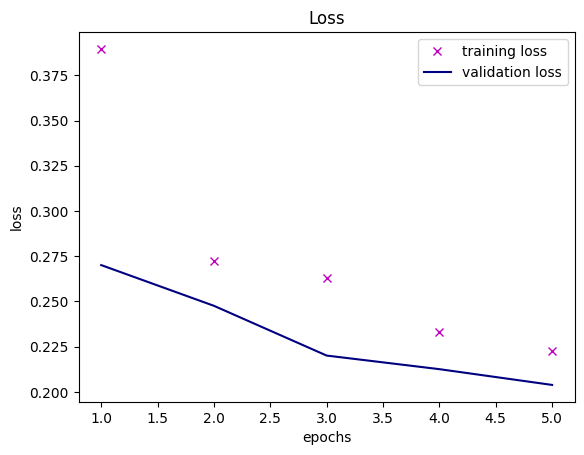

In [ ]:
# Wykres zmian straty w czasie uczenia modelu

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1,len(loss_values)+1)
plt.plot(epochs, loss_values, "mx", label='training loss')
plt.plot(epochs, val_loss_values, "navy", label = 'validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Loss')
plt.legend()

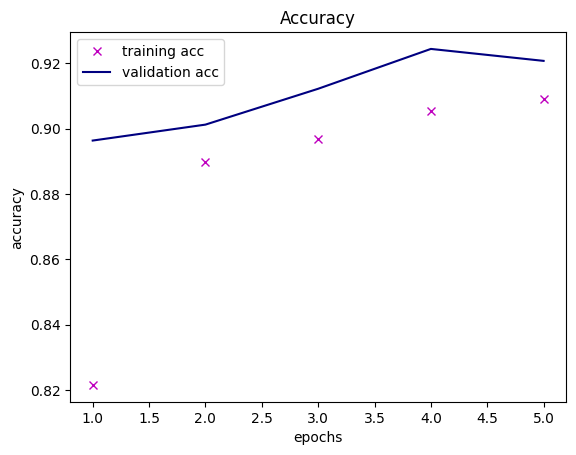

In [ ]:
# Wykres zmian dokładności w czasie uczenia modelu

history_dict = history.history
acc = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1,len(loss_values)+1)
plt.plot(epochs, acc, "mx", label='training acc')
plt.plot(epochs, val_acc_values, "navy", label = 'validation acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Accuracy')
plt.legend()

##**#2.4 - Budowa modelu analizy sentymentu [ELECTRA]**

Podział zbioru danych

In [ ]:
data = restaurant_data

data.rename(columns={'Rating':'label', 'Review':'text'}, inplace=True)
data.sample(5)

,text,label
8164,FOOD FEEL LIKE AFTERNOON PREPARED SEND DINNER,0
1760,GOOD FOOD BUT ADD SPICY UR ITEM SPICY LIKE PAN...,1
8607,ITS NICE PLACE I DO NOT GREAT EXPERIENCE HOME ...,0
4924,LOVE COLLECTION FLAVOUR INDIAN CUISINE HOMELY ...,1
820,THE OVERALL EXPERIENCE GOOD JUST THING I PARTI...,1


In [ ]:
# Podział zbioru na testowy i treningowy 10/90

from datasets import Dataset

dataset_ = Dataset.from_pandas(data)
dataset = dataset_.train_test_split(0.1)

Model analizy sentymentu
z fine-tuningiem modelu języka (poza podstawowym BERTem)

Model: ELECTRA

In [ ]:
# Model: ELECTRA

model_checkpoint = "google/electra-small-discriminator"
batch_size = 64

from transformers import AutoTokenizer

tokenizer_electra = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from transformers.pipelines.base import AutoModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model_electra = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Definicja funkcji do tokenizacji

def process(x):
  return tokenizer_electra(x['text'], truncation=True) # truncation = True, trzeba przyciąć zbyt długie sekwencje dla modelu ELECTRA (max = 512)

In [ ]:
# Tokenizacja

train_ds = dataset['train'].map(process)
test_ds = dataset['test'].map(process)

Map:   0%|          | 0/7380 [00:00<?, ? examples/s]

Map:   0%|          | 0/820 [00:00<?, ? examples/s]

In [ ]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [ ]:
from datasets import load_metric

metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

<ipython-input-63-20425849eca9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'sst2')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer = Trainer(
    model_electra,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer_electra,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate([train_ds[0]])

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.701393187046051,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.1463,
 'eval_samples_per_second': 6.834,
 'eval_steps_per_second': 6.834}

In [ ]:
# Trening modelu na danych

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.322237,0.913415
2,No log,0.249642,0.929268
3,No log,0.219228,0.921951
4,No log,0.209242,0.930488
5,0.297600,0.203930,0.931707


TrainOutput(global_step=580, training_loss=0.2828209054881129, metrics={'train_runtime': 257.747, 'train_samples_per_second': 143.164, 'train_steps_per_second': 2.25, 'total_flos': 507187482874416.0, 'train_loss': 0.2828209054881129, 'epoch': 5.0})

In [ ]:
# Charakterystyka wyuczonego modelu

trainer.model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

##**#3 - Testowanie modeli**

CNN

In [ ]:
# Definicja funkcji do testowania modelu CNN

def test_cnn_model(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=512)
    predictions = cnn_model.predict(data)
    predict = [0 if prob > 0.5 else 1 for prob in predictions]
    if predict == 0:
      print('This is a negative text')
    else:
      print('This is a positive text')

In [ ]:
# Test

text = 'chefs surely have no taste'

test_cnn_model(text)

1/1 [==============================] - 0s 59ms/step
This is a positive text


ELECTRA

In [ ]:
# Definicja funkcji do testowania modelu ELECTRA

def test_electra_model(text):
  inputs = tokenizer_electra(text, return_tensors='pt')
  device ='cuda' if torch.cuda.is_available() else 'cpu'
  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model_electra(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

  if predictions.item() == 0:
    print('This is a negative text')
  else:
    print('This is a positive text')


In [ ]:
# Test

text = 'chefs surely have no taste'

test_electra_model(text)

This is a negative text
